In [330]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.0.0'

In [331]:
#preparing and loading

weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) #matrix or tensor
y = weight*X + bias
print(X[:10])
print(y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [332]:
#Splitting data into training and test sets

train_split = int(0.8*len(X))
print(train_split)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(y_train))

40
40 40


In [333]:
#Visualization


def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions=y_preds):
    plt.figure(figsize=(10, 7))
    
    #blue training data
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    
    #green test data
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Prediction")
        
    plt.legend(prop={"size": 14})

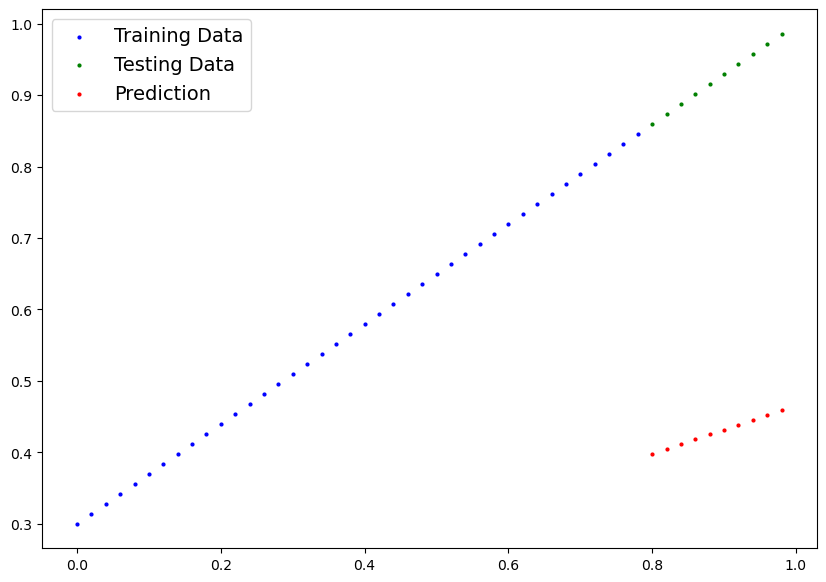

In [334]:
plot_predictions()

In [335]:
#Creating model

#random values ==> observe training data ==> adjust the random values ==> get close to ideal values

        
#gradient descent: method to estimate parameters from building the model

#backpropagation: Computes the gradient of the loss with respect for every model parameter to be updated

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) #the parameter the model try and learn
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))

    def forward(self, x):
        return self.weights*x + self.bias


In [336]:
#torch.nn: contains all of the bukding blocks for computational graphs
#torch.nn.Parameter: what the model try and learn, a Pytorch layer will usually set these by itself
#torch.nn.Module: the base class of neural network modules, need to override forward() if it is subclassed
#torch.optim: optimizers in PyTorch live, help with gradient descent --> reduce loss
#def forward(): all nn.Module subclassees require to overwrite, for computations in model

In [337]:
SEED = 42
torch.manual_seed(SEED)
model_0 = LinearRegressionModel()
model_0.state_dict()

#target: make weight and bias as close as possible to the ideal value

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [338]:
#making predictions
 
#try how well it predicts y_test given x_test

#inference mode: turns off gradeint tracking (torch.no_grad() performs the same thing)
with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [339]:
#Model Training

#target: train the model to move from unknown parameters to a better representation

#loss function: how wrong the model prediction is

loss_fn = nn.L1Loss()

#optimizer: adjusts the parameters by taking the loss of model into account

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01) #lr = learning rate

In [340]:
#training loop: 

torch.manual_seed(42)
#looping through the data
epochs = 200 #a loop through data
epoch_count = []
loss_values = []
test_loss_values = []
for epoch in range(epochs):
    model_0.train() #set model to training mode --> set all parameters that require gradients to require gradients
    
    #forward pass to make predictions
    y_pred = model_0(X_train)
    
    #calculate loss by comparing forward pass predictions to ground truth labels
    loss = loss_fn(y_pred, y_train)
    #print(loss)
    
    #optimizer zero grad
    optimizer.zero_grad()

    #loss backward to calculate the gradients of each parameter of the model wrt to the loss (backpropagation)
    loss.backward()

    #optimizer step to adjust model parameters and try to reduce the loss (gradient descent)
    optimizer.step()
    
    #testing
    model_0.eval() #set model to eval mode --> turn off gradient tracking
    with torch.inference_mode(): #test data, gradient tracking off now
        test_pred = model_0(X_test) #forward pass in test data
        test_loss = loss_fn(test_pred, y_test) #calculate loss on test data
    
    if epoch%10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)

In [341]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

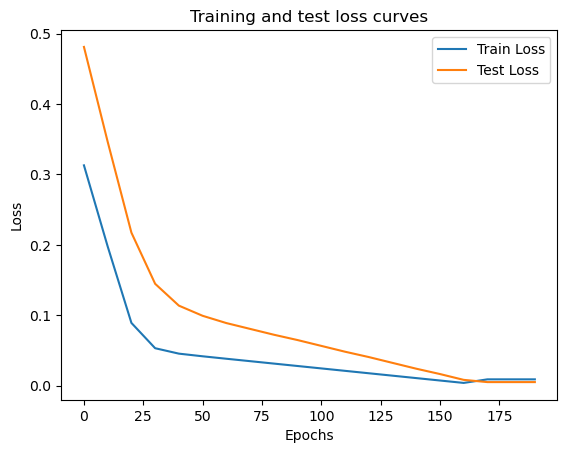

In [342]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).cpu().numpy()), label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

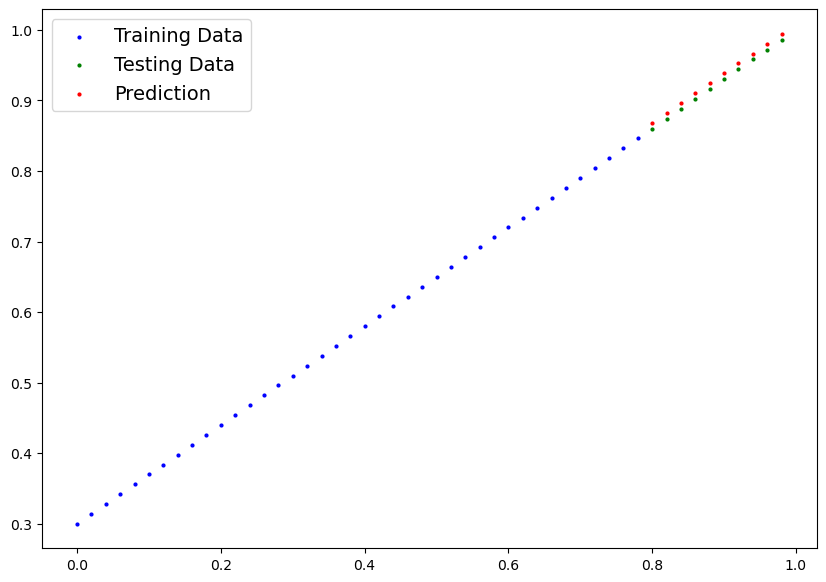

In [343]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)
    
plot_predictions(predictions=y_preds_new)

In [344]:
#saving and loading a model

from pathlib import Path
FILE_PATH = Path("models")
FILE_PATH.mkdir(parents=True, exist_ok=True)

#torch.save() --> save PyTorch object in Python pickle format
MODEL_NAME = "linear_regression_model.pth"
MODEL_SAVE_PATH = FILE_PATH/MODEL_NAME
#save state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

#torch.load() --> load a saved PyTorch Object (create a new instance and load the saved state_dict into it)
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model.state_dict()

#torch.nn.Module.load_state_dict() --> allows to load a models's saved state dictionary



OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [350]:
#checking after loading
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)
print(loaded_model_preds)

model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
print(y_preds)
print(loaded_model_preds == y_preds)

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])
tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])
tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])
